### TODOS: Wrap in Function, HPO, Class imbalance

In [1]:
import numpy as np
import pandas as pd 
import h5py

In [2]:
#Modelling libraries
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#from sklearn.feature_selection import VarianceThreshold <- use to remove low variance features

from bayes_opt import BayesianOptimization #!pip install bayesian-optimization

In [3]:
file_path = r"C:\Users\likai\Desktop\My Life\Master\3. Semester\Innolabs\Connectome Git\00_Data\Results"

In [4]:
data = pd.read_csv(file_path + '\\train.csv')
test = pd.read_csv(file_path + '\\test.csv')

In [5]:
data.head(2)

,ConnID,Repseudonym,siteid,age,visdat,sex,prmdiag,edyears,MEM_score,Apoe,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
0,85,3fd91223d,14,63,18.05.2016,1,0,13,1.215577,1.0,...,0.910899,0.423027,0.168445,0.086235,0.553605,0.260301,0.262766,-0.064755,-0.121692,1.193451
1,11,0f1b4b7ac,11,68,26.10.2017,1,2,13,-0.583224,1.0,...,0.381080,0.852528,0.141102,0.182648,0.196211,0.387882,0.299217,0.194711,0.191894,1.018621


In [6]:
#features.describe()
round(data.describe(), 2)

,ConnID,siteid,age,sex,prmdiag,edyears,MEM_score,Apoe,IDs,1_2,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
count,727.00,727.00,727.00,727.00,727.00,727.00,727.00,713.00,727.00,727.00,...,727.00,727.00,727.00,727.00,727.00,727.00,727.00,727.00,727.00,727.00
mean,459.86,10.61,70.91,0.60,1.39,14.58,0.02,0.35,459.86,0.71,...,0.50,0.40,0.04,0.13,0.54,0.08,0.17,0.06,0.09,0.50
std,263.98,5.27,6.13,0.57,1.20,2.98,1.00,0.48,263.98,0.27,...,0.22,0.20,0.18,0.20,0.24,0.20,0.21,0.17,0.18,0.23
min,1.00,2.00,60.00,0.00,0.00,6.00,-3.16,0.00,1.00,-0.02,...,-0.04,-0.25,-0.54,-0.46,-0.10,-0.70,-0.63,-0.58,-0.75,-0.55
25%,226.50,5.00,66.00,0.00,1.00,12.00,-0.47,0.00,226.50,0.53,...,0.35,0.26,-0.08,-0.01,0.38,-0.06,0.03,-0.05,-0.03,0.34
50%,465.00,11.00,71.00,1.00,1.00,14.00,0.28,0.00,465.00,0.70,...,0.50,0.40,0.04,0.12,0.53,0.08,0.16,0.05,0.09,0.48
75%,687.50,16.00,76.00,1.00,2.00,17.00,0.74,1.00,687.50,0.88,...,0.64,0.52,0.16,0.25,0.69,0.20,0.30,0.17,0.20,0.66
max,910.00,18.00,90.00,2.00,4.00,20.00,1.74,1.00,910.00,1.71,...,1.34,1.36,0.64,0.78,1.32,0.77,0.80,0.59,0.97,1.34


In [7]:
#define target
data['prmdiag'].value_counts()

1    283
0    181
2    124
3     80
4     59
Name: prmdiag, dtype: int64

In [8]:
has_alzheimer = data.prmdiag.isin([2,3])
no_alzheimer = data.prmdiag.isin([0])

data.loc[has_alzheimer, 'target'] = 1
data.loc[no_alzheimer, 'target'] = 0

In [9]:
data.dropna(subset=['target'], axis = 0, inplace = True)

In [10]:
data.drop(['ConnID','Repseudonym','visdat','siteid','IDs', 'prmdiag'], axis = 1, inplace = True)

In [11]:
features = data.drop('target', axis = 1)
labels = data['target']

In [12]:
n_features = features.shape[1]

In [13]:
#same for test file
has_alzheimer = test.prmdiag.isin([2,3])
no_alzheimer = test.prmdiag.isin([0])

test.loc[has_alzheimer, 'target'] = 1
test.loc[no_alzheimer, 'target'] = 0

In [14]:
test.dropna(subset=['target'], axis = 0, inplace = True)

In [15]:
test.drop(['ConnID','Repseudonym','visdat','siteid','IDs', 'prmdiag'], axis = 1, inplace = True)

In [16]:
X_test = test.drop('target', axis = 1)
y_test = test['target']

### Slight Class imbalance

In [17]:
labels.value_counts()

1.0    204
0.0    181
Name: target, dtype: int64

#### Train Test Split

In [18]:
#X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size = 0.2, random_state = 42, stratify = labels)
X_train, y_train = features, labels

#### impute missing values

In [19]:
features[features.isna().any(axis=1)]

,age,sex,edyears,MEM_score,Apoe,1_2,1_3,1_4,1_5,1_6,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
306,69,1,13,0.708661,NaN,0.565332,0.332528,-0.015577,0.527998,0.265987,...,0.575368,0.379398,0.153072,0.188878,0.463371,0.099339,0.027374,0.127089,0.073215,0.146653
348,70,0,20,0.991131,NaN,0.766746,0.788925,0.356687,0.639079,0.395056,...,0.559600,0.523757,-0.067733,-0.076038,1.023225,-0.154108,-0.135015,-0.031498,0.001101,0.925360
558,65,1,13,0.633007,NaN,0.180014,0.477626,0.143820,-0.054953,0.315783,...,0.222863,0.351755,-0.137550,0.203394,0.164663,0.234830,0.283645,-0.168066,-0.053491,0.241715
590,66,1,16,0.636514,NaN,0.599700,0.172902,-0.143808,0.145856,0.150976,...,0.254868,0.230583,-0.153607,-0.086144,0.356617,0.076132,0.228457,-0.031727,-0.084820,0.349648


In [20]:
imp = KNNImputer(missing_values=np.nan, n_neighbors=7)
X_train = imp.fit_transform(X_train)
#X_valid = imp.transform(X_valid)
X_test = imp.transform(X_test)

#### Scale Data

In [21]:
scaler = StandardScaler()

In [22]:
X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Fit RF

In [23]:
# Instantiate model with 500 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
#rf = RandomForestClassifier(n_estimators = 200, random_state = 42, max_depth = 10, max_features= int(n_features//6))
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(n_estimators=500, random_state=42)

### Evaluation

In [24]:
predictions = rf.predict(X_test)

In [25]:
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)
auc = roc_auc_score(y_test,predictions)

In [26]:
pd.DataFrame({"Accuracy":[accuracy], "Precision":[precision], "Recall": [recall], "F1":[f1], "AUC":[auc]})

,Accuracy,Precision,Recall,F1,AUC
0,0.764706,0.769231,0.833333,0.8,0.754505


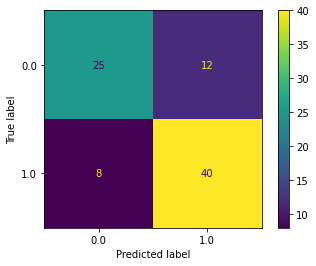

In [27]:
plot_confusion_matrix(rf, X_test, y_test)  

In [28]:
importances = list(rf.feature_importances_)

In [29]:
feature_list = list(features.columns)

feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:10]]

Variable: MEM_score            Importance: 0.0121178115
Variable: 5_217                Importance: 0.0015953671
Variable: age                  Importance: 0.0014523692
Variable: 187_218              Importance: 0.0013105861
Variable: 187_217              Importance: 0.0012904794
Variable: 23_228               Importance: 0.001279248
Variable: 9_172                Importance: 0.0012692836
Variable: 2_167                Importance: 0.001262036
Variable: 31_103               Importance: 0.0011852372
Variable: 41_215               Importance: 0.0011368802


[None, None, None, None, None, None, None, None, None, None]

## Logistic Regression

In [30]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga')

In [31]:
params_grid = {
                 'l1_ratio': np.linspace(0,  1, 11)
             }

In [32]:
grid_clf =  GridSearchCV(estimator = logreg, param_grid = params_grid, n_jobs = -1, cv = 10, verbose=3)

In [33]:
grid_clf.fit(X_train, y_train)


Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  8.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid={'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             verbose=3)

In [34]:
grid_clf.best_estimator_

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [35]:
grid_clf. best_params_

{'l1_ratio': 0.5}

In [36]:
logreg = LogisticRegression(penalty = 'l2', solver = 'lbfgs')
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)
auc = roc_auc_score(y_test,predictions)

In [38]:
pd.DataFrame({"Accuracy":[accuracy], "Precision":[precision], "Recall": [recall], "F1":[f1], "AUC":[auc]})

,Accuracy,Precision,Recall,F1,AUC
0,0.752941,0.787234,0.770833,0.778947,0.750282


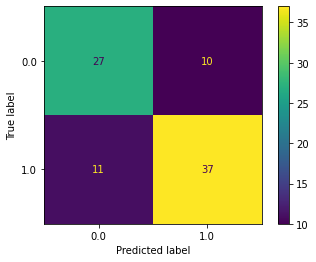

In [39]:
plot_confusion_matrix(logreg, X_test, y_test)  

### PCA Pipeline - Test

In [40]:
#X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size = 0.2, random_state = 42, stratify = labels)
X_train, y_train = features, labels

X_test = test.drop('target', axis = 1)
y_test = test['target']

In [41]:
pipeline = Pipeline([
    ('KNN_Impute', KNNImputer(missing_values=np.nan, n_neighbors=7)),
    ('scale', StandardScaler()),
    ('PCA', PCA(n_components = .95)),
])


In [42]:
X_train = pipeline.fit_transform(X_train)

In [43]:
X_test = pipeline.transform(X_test)

In [44]:
X_train.shape[1] == X_test.shape[1]

True

In [45]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga')

In [46]:
params_grid = {
                 'l1_ratio': np.linspace(0,  1, 11)
             }

In [47]:
grd_search = GridSearchCV(estimator = logreg, param_grid = params_grid, n_jobs = -1, cv = 10, verbose=3)

In [48]:
grd_search.fit(X_train, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  95 out of 110 | elapsed:    4.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    4.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid={'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             verbose=3)

In [49]:
grd_search.best_params_

{'l1_ratio': 0.8}

In [50]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = .9)

In [51]:
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=0.9, penalty='elasticnet', solver='saga')

In [52]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [53]:
log_pred = logreg.predict(X_test)
rf_pred = rf.predict(X_test)

In [54]:
model = ['LogReg', 'RF']
accuracy = []
precision = []
recall = []
f1 = []
auc =  []

In [55]:
#logreg
accuracy.append(accuracy_score(y_test,log_pred))
precision.append(precision_score(y_test,log_pred))
recall.append(recall_score(y_test,log_pred))
f1.append(f1_score(y_test,log_pred))
auc.append(roc_auc_score(y_test,log_pred))
#rf
accuracy.append(accuracy_score(y_test,rf_pred))
precision.append(precision_score(y_test,rf_pred))
recall.append(recall_score(y_test,rf_pred))
f1.append(f1_score(y_test,rf_pred))
auc.append(roc_auc_score(y_test,rf_pred))

In [56]:
pd.DataFrame({'Model': model, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1":f1, "AUC":auc})

,Model,Accuracy,Precision,Recall,F1,AUC
0,LogReg,0.741176,0.809524,0.708333,0.755556,0.746059
1,RF,0.623529,0.605263,0.958333,0.741935,0.573761


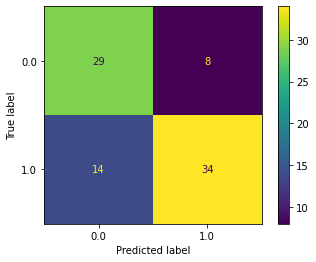

In [57]:
plot_confusion_matrix(logreg, X_test, y_test)  

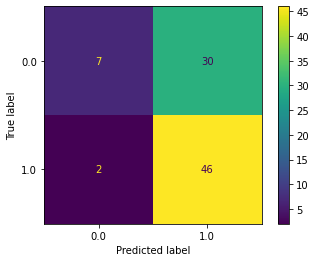

In [58]:
plot_confusion_matrix(rf, X_test, y_test)  